In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

Library seperti os digunakan untuk mengelola file dan direktori, sedangkan cv2 dari OpenCV. matplotlib.pyplot dan seaborn digunakan untuk visualisasi data dan hasil analisis. numpy dan pandas adalah pustaka fundamental untuk pengolahan array dan manipulasi data tabel. Untuk fitur dan tekstur gambar, digunakan graycomatrix dan graycoprops dari skimage, serta entropy dari scipy.stats. Library sklearn menyediakan berbagai alat penting dalam machine learning, seperti pemisahan data (train_test_split), validasi silang (cross_val_predict), pemodelan menggunakan algoritma seperti Random Forest, SVM, dan K-Nearest Neighbors, serta evaluasi performa model melalui metrik seperti akurasi, presisi, recall, F1-score, dan confusion matrix. Keseluruhan library ini bekerja sama untuk membangun sistem analisis citra berbasis machine learning yang terstruktur dan efisien.

## Define Resize Function

In [2]:
def resize(image, new_row, new_column):
    row, column = image.shape
    new_image = np.zeros((new_row, new_column), dtype=np.uint8)
    for i in range(new_row):
        for j in range(new_column):
            x = int(i * row / new_row)
            y = int(j * column / new_column)
            x = min(x, row - 1)
            y = min(y, column - 1)
            new_image[i, j] = image[x, y]
    return new_image

Fungsi di atas merupakan fungsi resize manual yang digunakan untuk mengubah ukuran citra grayscale ke dimensi baru dengan metode nearest neighbor. Setiap piksel pada citra hasil mengambil nilai dari piksel terdekat di citra asli berdasarkan skala. Fungsi ini membantu standarisasi ukuran citra sebelum proses ekstraksi fitur dalam sistem analisis citra berbasis machine learning.

## Define Display Function

In [3]:
def display(data, labels, samples_per_label=5):
    unique_labels = np.unique(labels)
    num_unique_labels = len(unique_labels)

    plt.figure(figsize=(samples_per_label * 2, num_unique_labels * 2))

    for i, label in enumerate(unique_labels):
        indices = np.where(labels == label)[0]

        if len(indices) == 0:
            print(f"Tidak ada gambar ditemukan untuk label: {label}")
            continue

        selected_indices = indices[:samples_per_label]

        for j, idx in enumerate(selected_indices):
            plt.subplot(num_unique_labels, samples_per_label, i * samples_per_label + j + 1)
            plt.imshow(data[idx], cmap='gray')
            plt.axis('off')

            if j == 0:
                plt.title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

Fungsi ini secara umum digunakan untuk menampilkan contoh-contoh gambar dari setiap kategori dalam dataset secara terstruktur. Gambar-gambar ditampilkan dalam grid, di mana setiap baris dikelompokkan berdasarkan label atau kelas yang berbeda. Untuk setiap kategori, sejumlah gambar akan ditampilkan dalam beberapa baris dan kolom sesuai jumlah yang telah ditentukan. Fungsi ini membantu dalam memvisualisasikan sebaran data dan memastikan bahwa gambar dalam setiap kategori telah dimuat dengan benar. Judul label ditampilkan hanya sekali di bagian atas blok gambar agar lebih jelas dan tidak membingungkan.


## Data Loading

In [4]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = resize(img, 256, 256)
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)

data = np.array(data)
labels = np.array(labels)

Fungsi pemuatan data ini secara umum bertujuan untuk membaca seluruh gambar dari suatu folder dataset yang tersusun berdasarkan kategori. Setiap gambar yang ditemukan akan diproses dengan cara diubah ke format hitam putih dan disesuaikan ukurannya agar seragam. Proses ini juga menyaring gambar yang rusak atau tidak bisa dibaca. Setelah itu, semua gambar yang telah diproses, beserta informasi kategorinya, dikumpulkan dan disiapkan dalam bentuk struktur data yang rapi agar dapat digunakan pada tahap analisis atau pelatihan model selanjutnya.


## Define Median Function

In [5]:
def median(image, size):
    paddedImage = np.pad(image, ((size//2, size//2), (size//2, size//2)), mode='edge')
    newImage = np.zeros(image.shape)

    for y in range(image.shape[1]):
        for x in range(image.shape[0]):
            area = paddedImage[y:y + size, x:x + size]
            values = area.flatten()
            sortedValues = sorted(values)
            medianValue = sortedValues[len(sortedValues) // 2]
            newImage[y, x] = medianValue
    return newImage

Fungsi diatas bertujuan untuk melakukan median filtering pada citra. Gambar akan diperluas di sekelilingnya agar setiap piksel memiliki area sebesar size × size. Lalu, untuk setiap piksel, fungsi mengambil area sekitarnya, meratakannya menjadi array, mengurutkan nilainya, dan mengambil nilai tengah (median), yang kemudian digunakan sebagai nilai baru piksel tersebut. 

In [6]:
data_preprocessed = []
labels_preprocessed = []

for i in range(len(data)):
    img = data[i]
    lbl = labels[i]

    img_median = median(img, 3)
    data_preprocessed.append(img_median)
    labels_preprocessed.append(lbl)

data_preprocessed = np.array(data_preprocessed)
labels_preprocessed = np.array(labels_preprocessed)

Bagian kode diatas melakukan preprocessing data citra dengan menerapkan filter median berukuran 3×3 pada setiap gambar dalam dataset data, lalu hasilnya disimpan dalam data_preprocessed, sementara label tetap disimpan dalam labels_preprocessed. Setelah seluruh data selesai diproses, kedua list tersebut dikonversi menjadi array.

# FEATURE EXTRACTION

In [7]:
def glcm(image, derajat):
    if image.dtype != np.uint8 and image.dtype != np.uint16:
        image = (image * 255).astype(np.uint8)

    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")

    glcm = graycomatrix(image, [1], angles, levels=256, symmetric=True, normed=True)
    return glcm

Fungsi `glcm` digunakan untuk menghitung matriks GLCM dari citra berdasarkan arah tertentu (0°, 45°, 90°, atau 135°). Matriks ini merepresentasikan pola tekstur citra berdasarkan hubungan antar piksel dalam arah yang dipilih.


In [8]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Fungsi ini digunakan untuk menghitung nilai **correlation** dari matriks GLCM. Nilai ini menggambarkan hubungan linear antar piksel dalam tekstur citra.


In [9]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Fungsi ini digunakan untuk menghitung nilai **dissimilarity** dari matriks GLCM, yang menunjukkan seberapa berbeda nilai piksel yang berdekatan dalam tekstur citra.


In [10]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Fungsi ini digunakan untuk menghitung nilai **homogeneity** dari matriks GLCM, yang mengukur keseragaman tekstur dengan melihat seberapa mirip nilai piksel yang berdekatan.


In [11]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Fungsi ini digunakan untuk menghitung nilai **contrast** dari matriks GLCM, yang mengukur tingkat perbedaan atau variasi intensitas piksel dalam tekstur citra.


In [12]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Fungsi ini digunakan untuk menghitung nilai **ASM** (Angular Second Moment) dari matriks GLCM, yang mengukur keteraturan atau energi tekstur citra.


In [13]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Fungsi ini digunakan untuk menghitung nilai **energy** dari matriks GLCM, yang menunjukkan kekuatan atau intensitas tekstur citra berdasarkan konsentrasi pola tertentu.


In [14]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Fungsi ini digunakan untuk menghitung nilai **entropy** dari matriks GLCM, yang mengukur tingkat ketidakpastian atau kompleksitas tekstur citra.


In [15]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(data_preprocessed)):
    D0 = glcm(data_preprocessed[i], 0)
    D45 = glcm(data_preprocessed[i], 45)
    D90 = glcm(data_preprocessed[i], 90)
    D135 = glcm(data_preprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode ini melakukan perhitungan matriks GLCM untuk setiap gambar dalam data pada empat arah sudut berbeda: 0°, 45°, 90°, dan 135°. Hasil matriks GLCM dari masing-masing arah tersebut disimpan secara terpisah dalam daftar yang sesuai, sehingga memudahkan analisis tekstur citra berdasarkan berbagai orientasi piksel.


In [16]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

Kode ini mendefinisikan beberapa daftar kosong untuk menyimpan hasil ekstraksi fitur tekstur dari matriks GLCM pada empat arah sudut berbeda (0°, 45°, 90°, dan 135°). Setiap fitur seperti kontras, dissimilarity, homogenitas, entropi, ASM, energi, dan korelasi akan dikumpulkan secara terpisah berdasarkan arah sudutnya.


In [17]:
for i in range(len(data_preprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Kode ini menghitung nilai korelasi tekstur dari setiap matriks GLCM yang sudah dibuat untuk masing-masing arah sudut (0°, 45°, 90°, dan 135°) pada seluruh data gambar. Hasil nilai korelasi tersebut kemudian disimpan ke dalam daftar yang sesuai untuk setiap arah sudut.


In [18]:
for i in range(len(data_preprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode ini menghitung nilai kontras tekstur dari setiap matriks GLCM pada empat arah sudut (0°, 45°, 90°, dan 135°) untuk seluruh data gambar. Setiap hasil kontras yang diperoleh kemudian disimpan ke dalam daftar yang sesuai berdasarkan arah sudutnya.


In [19]:
for i in range(len(data_preprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode ini digunakan untuk menghitung nilai dissimilarity dari matriks GLCM pada empat arah sudut (0°, 45°, 90°, dan 135°) untuk setiap gambar dalam data. Nilai dissimilarity yang diperoleh kemudian disimpan secara terpisah dalam daftar sesuai dengan arah sudutnya.


In [20]:
for i in range(len(data_preprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Kode ini menghitung nilai homogenitas dari matriks GLCM pada empat arah sudut (0°, 45°, 90°, dan 135°) untuk setiap gambar dalam data. Nilai homogenitas tersebut kemudian disimpan dalam daftar terpisah sesuai dengan arah sudutnya.


In [21]:
for i in range(len(data_preprocessed)):
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Kode ini menghitung nilai entropi dari matriks GLCM pada empat arah sudut (0°, 45°, 90°, dan 135°) untuk setiap gambar dalam data. Nilai entropi tersebut kemudian disimpan dalam daftar terpisah sesuai dengan arah sudutnya.


In [22]:
for i in range(len(data_preprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode ini menghitung nilai ASM (Angular Second Moment) dari matriks GLCM pada empat arah sudut (0°, 45°, 90°, dan 135°) untuk setiap gambar dalam data. Hasil nilai ASM disimpan secara terpisah dalam daftar sesuai dengan arah sudutnya.


In [23]:
for i in range(len(data_preprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode ini menghitung nilai energy dari matriks GLCM pada empat arah sudut (0°, 45°, 90°, dan 135°) untuk setiap gambar dalam data. Hasil nilai energy tersebut kemudian disimpan dalam daftar terpisah sesuai dengan arah sudutnya.


### Extraction results to CSV 

Kode ini menggabungkan semua fitur tekstur hasil ekstraksi beserta nama file dan labelnya ke dalam sebuah tabel (DataFrame) menggunakan pandas. Setelah itu, tabel tersebut disimpan ke file CSV untuk penyimpanan dan analisis selanjutnya, lalu file CSV tersebut dibaca kembali dan ditampilkan sebagai output.


In [24]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,freshPotato (1).png,fresh,90.695129,143.334010,98.988266,136.190850,0.644336,0.572157,0.650819,0.583527,...,0.088684,0.085838,0.297832,0.293010,0.297799,0.292982,0.981398,0.970558,0.979697,0.972025
1,freshPotato (10).png,fresh,19.240809,35.808351,24.684314,31.644567,0.899623,0.879375,0.915373,0.883205,...,0.558660,0.554352,0.746256,0.744664,0.747435,0.744548,0.987389,0.976592,0.983821,0.979314
2,freshPotato (11).png,fresh,82.398100,151.639339,120.194730,157.304883,0.808650,0.774525,0.801748,0.774500,...,0.501018,0.498135,0.709056,0.706340,0.707826,0.705787,0.979875,0.963058,0.970643,0.961678
3,freshPotato (12).png,fresh,43.429810,96.650673,81.415656,97.599662,0.770152,0.714767,0.753254,0.719638,...,0.298716,0.295371,0.547023,0.543534,0.546549,0.543480,0.987685,0.972615,0.976905,0.972346
4,freshPotato (13).png,fresh,75.167586,131.196340,83.491452,101.380577,0.794964,0.763849,0.803831,0.769582,...,0.448964,0.446605,0.670218,0.667129,0.670048,0.668285,0.988099,0.979273,0.986781,0.983984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,rottenPotato (73).png,rotten,188.335907,259.274541,184.611229,319.341376,0.736264,0.715808,0.735220,0.701614,...,0.374588,0.370656,0.610844,0.610116,0.612036,0.608815,0.980790,0.973594,0.981159,0.967477
146,rottenPotato (74).png,rotten,219.232613,412.887305,312.838266,368.298454,0.703989,0.669294,0.698999,0.668345,...,0.370088,0.368311,0.609775,0.606410,0.608349,0.606886,0.977648,0.957977,0.968124,0.962515
147,rottenPotato (75).png,rotten,183.396814,344.899039,259.320282,316.077140,0.731745,0.701220,0.732472,0.699148,...,0.378873,0.376253,0.616475,0.612904,0.615527,0.613395,0.985535,0.972841,0.979546,0.975111
148,rottenPotato (8).png,rotten,116.002083,181.146882,106.775858,162.313295,0.793607,0.767101,0.803330,0.769277,...,0.495679,0.492584,0.703913,0.701457,0.704045,0.701843,0.986237,0.978559,0.987331,0.980789


# FEATURE SELECTION

Kode ini melakukan analisis korelasi antar fitur hasil ekstraksi untuk memilih fitur yang tidak terlalu berkorelasi tinggi satu sama lain (threshold korelasi ≥ 0.95 digunakan sebagai batas penghapusan fitur yang sangat mirip). Fitur yang dipilih kemudian disimpan sebagai dataset baru, dan label asli dipisahkan. Terakhir, sebuah heatmap korelasi dari fitur terpilih ditampilkan menggunakan seaborn untuk memvisualisasikan hubungan antar fitur.


<Axes: >

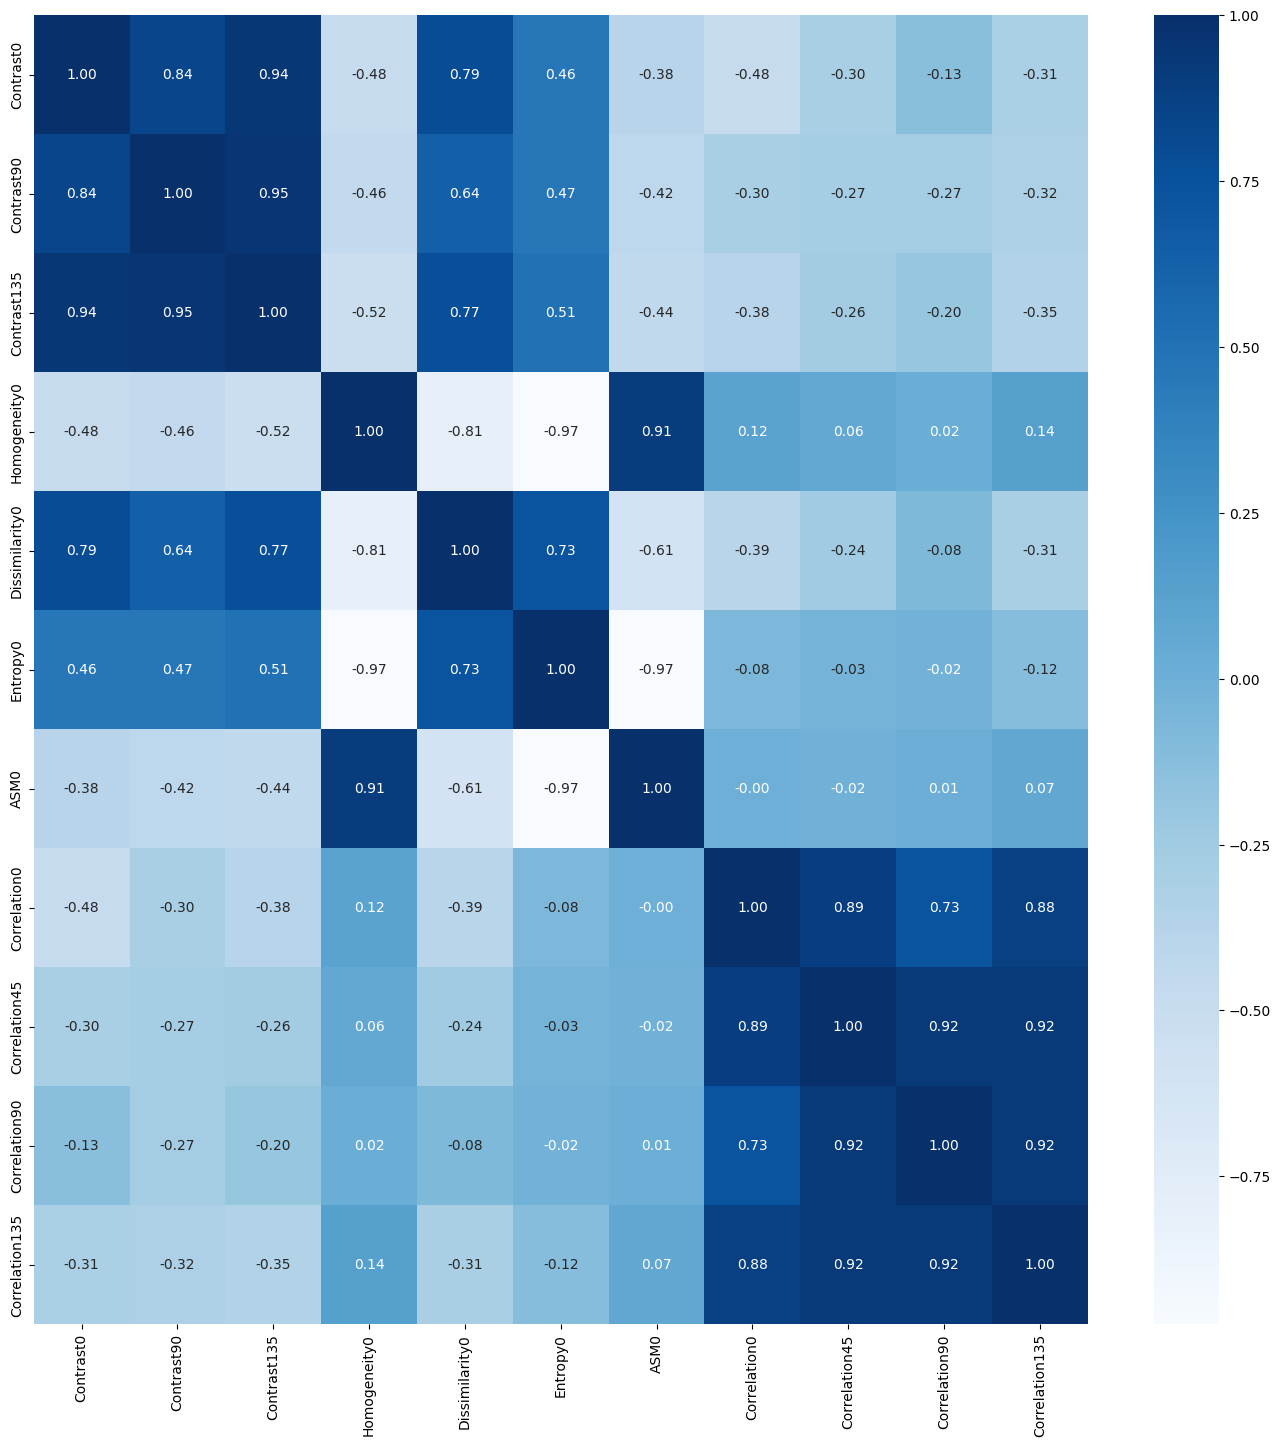

In [25]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

# SPLITTING DATA

In [26]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(120, 11)
(30, 11)


Kode ini membagi data fitur dan label menjadi dua bagian: data latih (training) dan data uji (testing). Parameter `test_size=0.3` berarti 30% data digunakan untuk pengujian, dan sisanya 70% untuk pelatihan. `random_state=42` memastikan pembagian data bisa direproduksi. Setelah pembagian, ukuran masing-masing subset ditampilkan untuk memastikan pembagian berjalan sesuai harapan.


# Feature Normalization

In [27]:
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Kode ini melakukan **normalisasi fitur** menggunakan metode standardisasi (z-score normalization). Data pada `X_train` dan `X_test` diubah sehingga setiap fitur memiliki nilai rata-rata 0 dan standar deviasi 1 berdasarkan statistik dari data training (`X_train`). Hal ini penting supaya model belajar dengan data yang sudah distandarisasi dan agar distribusi fitur pada data uji konsisten dengan data latih.


# MODELING

## DEFINE MODEL

In [28]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Fungsi ini berfungsi untuk menampilkan hasil evaluasi dari model klasifikasi, termasuk metrik seperti precision, recall, f1-score, matriks kebingungan, dan tingkat akurasi. Selain itu, tiga algoritma klasifikasi yang umum digunakan didefinisikan, yaitu Random Forest, Support Vector Machine (SVM), dan K-Nearest Neighbors (KNN). Ketiga model tersebut nantinya dapat digunakan untuk melatih dan menguji performa klasifikasi pada data yang tersedia.


### Train Random Forest Classifier

Fungsi kode ini adalah untuk melatih model Random Forest agar dapat mengenali pola pada data pelatihan, kemudian menguji kemampuan model tersebut dalam memprediksi data baru (data pengujian). Dengan melihat hasil evaluasi dari prediksi pada data pelatihan dan pengujian, kita dapat menilai seberapa akurat dan andal model dalam mengklasifikasikan data. Jadi, fungsi utamanya adalah membangun dan mengevaluasi model klasifikasi secara menyeluruh.


In [29]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       fresh       0.92      0.98      0.95        59
      rotten       0.98      0.92      0.95        61

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120

[[58  1]
 [ 5 56]]
Accuracy: 0.95

------Testing Set------
              precision    recall  f1-score   support

       fresh       0.83      0.94      0.88        16
      rotten       0.92      0.79      0.85        14

    accuracy                           0.87        30
   macro avg       0.88      0.86      0.86        30
weighted avg       0.87      0.87      0.87        30

[[15  1]
 [ 3 11]]
Accuracy: 0.8666666666666667


### Train SVM Classifier

Kode ini melatih model Support Vector Machine (SVM) menggunakan data pelatihan, kemudian membuat prediksi pada data pelatihan dan data pengujian. Selanjutnya, hasil prediksi tersebut dievaluasi dengan menggunakan laporan klasifikasi dan matriks kebingungan untuk menilai performa model. Tujuannya adalah mengetahui seberapa baik model SVM dapat mengenali pola dan mengklasifikasikan data baik saat pelatihan maupun pengujian.


In [30]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       fresh       0.79      0.95      0.86        59
      rotten       0.94      0.75      0.84        61

    accuracy                           0.85       120
   macro avg       0.86      0.85      0.85       120
weighted avg       0.87      0.85      0.85       120

[[56  3]
 [15 46]]
Accuracy: 0.85

------Testing Set------
              precision    recall  f1-score   support

       fresh       0.88      0.94      0.91        16
      rotten       0.92      0.86      0.89        14

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30

[[15  1]
 [ 2 12]]
Accuracy: 0.9


### Train KNN Classifier

Kode ini digunakan untuk melatih model K-Nearest Neighbors (KNN) dengan data pelatihan, lalu membuat prediksi pada data pelatihan dan data pengujian. Setelah itu, hasil prediksi dievaluasi menggunakan laporan klasifikasi dan matriks kebingungan untuk menilai performa model. Tujuannya adalah mengukur seberapa baik model KNN dalam mengklasifikasikan data berdasarkan kedekatan dengan data latih yang sudah ada.


In [31]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       fresh       0.86      0.81      0.83        59
      rotten       0.83      0.87      0.85        61

    accuracy                           0.84       120
   macro avg       0.84      0.84      0.84       120
weighted avg       0.84      0.84      0.84       120

[[48 11]
 [ 8 53]]
Accuracy: 0.8416666666666667

------Testing Set------
              precision    recall  f1-score   support

       fresh       0.87      0.81      0.84        16
      rotten       0.80      0.86      0.83        14

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30

[[13  3]
 [ 2 12]]
Accuracy: 0.8333333333333334


## Evaluation With Confusion Matrix

Fungsi `plot_confusion_matrix` ini digunakan untuk menampilkan matriks kebingungan dari hasil prediksi sebuah model. Matriks kebingungan membantu melihat performa klasifikasi dengan memperlihatkan jumlah prediksi benar dan salah untuk setiap kelas. Kemudian, fungsi ini dipanggil untuk menampilkan matriks kebingungan dari tiga model yang sudah dilatih: Random Forest, SVM, dan KNN, agar kita bisa membandingkan hasil klasifikasi masing-masing model secara visual.


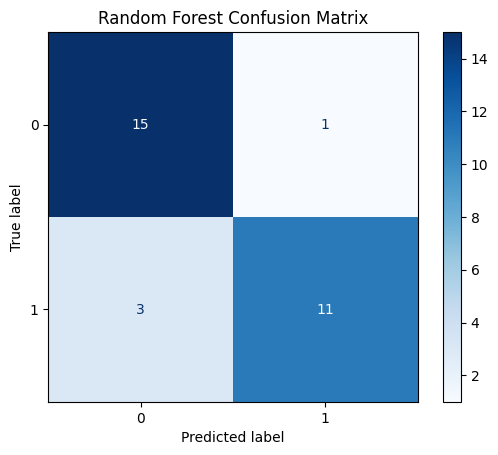

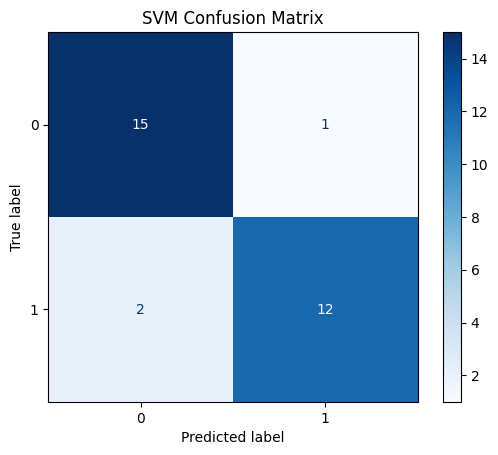

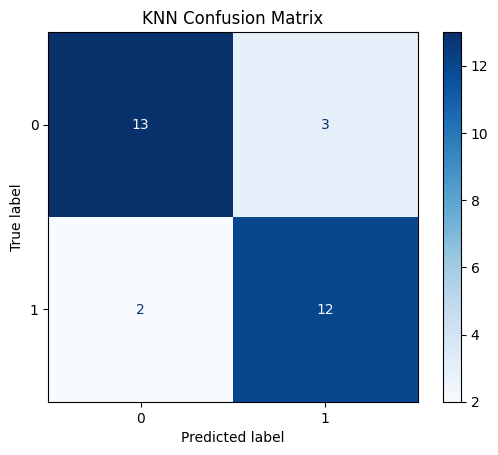

In [32]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")